In [3]:
import numpy as np
import pandas as pd
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt


import seaborn as sns
# sns.set_style("whitegrid")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics


from keras.layers import Dense, Dropout, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.layers import SpatialDropout1D

from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings("ignore")

In [4]:
# Reading clean cicids2017 csv file
df = pd.read_csv('data/Cleaned_Dataset_CICIDS2017.csv')

In [5]:
print("Columns in dataframe:\n")
columns = [col for col in df.columns]
print(columns)

Columns in dataframe:

['DestinationPort', 'FlowDuration', 'TotalFwdPackets', 'TotalBackwardPackets', 'TotalLengthofFwdPackets', 'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin', 'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax', 'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd', 'FlowBytes/s', 'FlowPackets/s', 'FlowIATMean', 'FlowIATStd', 'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd', 'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd', 'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets/s', 'BwdPackets/s', 'MinPacketLength', 'MaxPacketLength', 'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance', 'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount', 'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount', 'Down/UpRatio', 'AveragePacketSize', 'AvgFwdSegmentSize', 'AvgBwdSegmentSize', 'Fw

In [6]:
print("Total no. of columns: {}".format(len(columns)))

Total no. of columns: 79


In [7]:
# Class of attacks
print(df['Label'].unique())

['BENIGN' 'FTPPatator' 'SSHPatator' 'DoS_slowloris' 'DoS_Slowhttptest'
 'DoS_Hulk' 'DoS_GoldenEye' 'Heartbleed' 'Web_Attack_Brute_Force'
 'Web_Attack_XSS' 'Web_Attack_Sql_Injection' 'Infiltration' 'Bot'
 'PortScan' 'DDoS']


In [8]:
# Total number of samples in each class of attacks
print(df['Label'].value_counts())

Label
BENIGN                      2035505
DoS_Hulk                     171509
DDoS                         128005
PortScan                      57305
DoS_GoldenEye                 10279
FTPPatator                     5480
DoS_slowloris                  5289
DoS_Slowhttptest               5176
SSHPatator                     3071
Bot                            1943
Web_Attack_Brute_Force         1445
Web_Attack_XSS                  652
Infiltration                     36
Web_Attack_Sql_Injection         21
Heartbleed                       11
Name: count, dtype: int64


In [9]:
labels = df['Label'].unique()
values = df['Label'].value_counts().tolist()
values_percentage =[ value / len(df['Label']) for value in values]
data = {'Family': labels,
       'Total_Samples': values,
       'Sample_percentate':values_percentage}
df_percentage = pd.DataFrame(data)
print(df_percentage)

                      Family  Total_Samples  Sample_percentate
0                     BENIGN        2035505           0.839132
1                 FTPPatator         171509           0.070704
2                 SSHPatator         128005           0.052770
3              DoS_slowloris          57305           0.023624
4           DoS_Slowhttptest          10279           0.004237
5                   DoS_Hulk           5480           0.002259
6              DoS_GoldenEye           5289           0.002180
7                 Heartbleed           5176           0.002134
8     Web_Attack_Brute_Force           3071           0.001266
9             Web_Attack_XSS           1943           0.000801
10  Web_Attack_Sql_Injection           1445           0.000596
11              Infiltration            652           0.000269
12                       Bot             36           0.000015
13                  PortScan             21           0.000009
14                      DDoS             11           0

# Bar chart representation for each class

In [10]:
def show_class_distribution(df: pd.DataFrame, title: str) -> None:
    plt.figure(figsize=(20,6), dpi=100)
    nums = df["Label"].value_counts().sort_index()
    ax = sns.barplot(x=nums.index, y=nums.values)
    ax.set(xlabel="Class", ylabel="Number of Samples", title=title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    # plt.savefig("packet_distribution")
    plt.grid(True)
    plt.show()

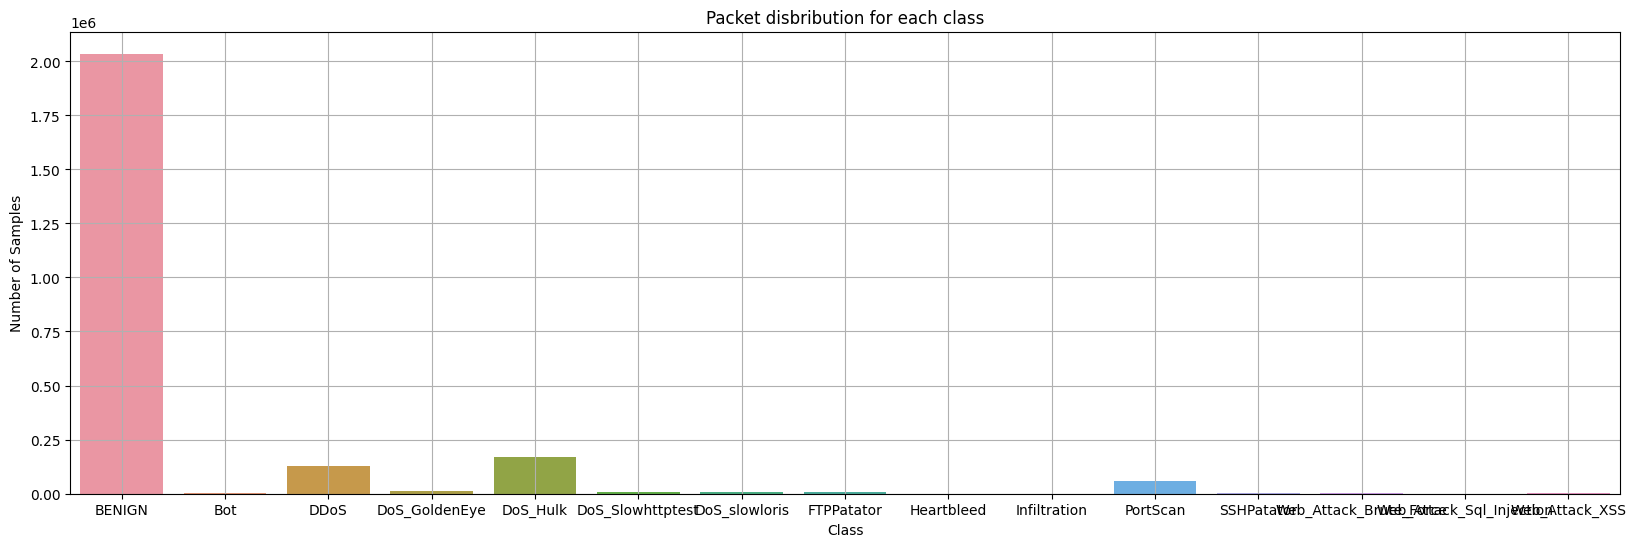

In [11]:
show_class_distribution(df, 'Packet disbribution for each class')

# Family Class grouping

In [12]:
#temporary dataframe
df1 = df
df_Benign = df1[df1['Label']=='BENIGN']
df_Malicious =  df1[df1['Label'] != 'BENIGN']
print(df_Benign.shape)
print(df_Benign['Label'].value_counts())


(2035505, 79)
Label
BENIGN    2035505
Name: count, dtype: int64


In [13]:
# sampling only 50% of Benign samples
df_Benign = df_Benign.sample(frac=0.2)
print("After 50% sample of Benign class, shape of df_Benigh: ",df_Benign.shape)

#contatinating two dataframe
df1 = pd.concat([df_Benign, df_Malicious])
df1=df1.sample(frac=1).reset_index(drop=True)
df1

After 50% sample of Benign class, shape of df_Benigh:  (407101, 79)


,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,53.0,184.0,2.0,2.0,68.0,262.0,34.0,34.0,34.000000,0.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,80.0,84760202.0,7.0,7.0,1092.0,11595.0,360.0,0.0,156.000000,190.840247,...,20.0,9993.0,0.0,9993.0,9993.0,84200000.0,0.0,84200000.0,84200000.0,DoS_Hulk
2,53.0,24144.0,2.0,2.0,74.0,188.0,37.0,37.0,37.000000,0.000000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,80.0,976089.0,3.0,3.0,26.0,11601.0,20.0,0.0,8.666667,10.263203,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS
4,80.0,2092017.0,5.0,0.0,30.0,0.0,6.0,6.0,6.000000,0.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797318,50918.0,118.0,1.0,1.0,6.0,6.0,6.0,6.0,6.000000,0.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
797319,80.0,85067082.0,7.0,6.0,365.0,11595.0,359.0,0.0,52.142857,135.329756,...,20.0,979.0,0.0,979.0,979.0,84900000.0,0.0,84900000.0,84900000.0,DoS_Hulk
797320,443.0,5620655.0,9.0,6.0,367.0,3710.0,210.0,0.0,40.777778,75.805306,...,32.0,149919.0,0.0,149919.0,149919.0,5470732.0,0.0,5470732.0,5470732.0,BENIGN
797321,80.0,11419690.0,5.0,4.0,406.0,3525.0,406.0,0.0,81.200000,181.568720,...,32.0,913.0,0.0,913.0,913.0,6413588.0,0.0,6413588.0,6413588.0,DoS_GoldenEye


In [14]:
DoS_Labels =  ['Dos_Hulk', 'DoS_GoldenEye', 'DoS_slowloris', 'DoS_Slowhttptest']
Web_Labels = ['Web_Attack_Brute_Force', 'Web_Attack_XSS', 'Web_Attack_Sql_Injection']


In [15]:
print("Before resmapling:\m")
df1['Label'].unique()

Before resmapling:\m


array(['BENIGN', 'DoS_Hulk', 'DDoS', 'SSHPatator', 'PortScan',
       'DoS_GoldenEye', 'DoS_Slowhttptest', 'FTPPatator', 'Bot',
       'DoS_slowloris', 'Web_Attack_Brute_Force', 'Web_Attack_XSS',
       'Infiltration', 'Heartbleed', 'Web_Attack_Sql_Injection'],
      dtype=object)

In [16]:
# df1.loc[df1['Label'] == "DoS_Hulk", "Label"] = 'DoS'


In [17]:
for i in DoS_Labels:
    df1.loc[df1['Label'] == i, "Label"] = 'DoS'
for i in Web_Labels:
    df1.loc[df1['Label'] == i, "Label"] = 'Web_Attack'

# Drop row having label equal to 'infiltration' and 'heartbleed' in dataframe
df1 = df1.drop(df1[df1['Label'] == 'Infiltration'].index)
df1 = df1.drop(df1[df1['Label'] == 'Heartbleed'].index)
    

In [18]:
print(df1['Label'].value_counts())

Label
BENIGN        407101
DoS_Hulk      171509
DDoS          128005
PortScan       57305
DoS            20744
FTPPatator      5480
SSHPatator      3071
Web_Attack      2118
Bot             1943
Name: count, dtype: int64


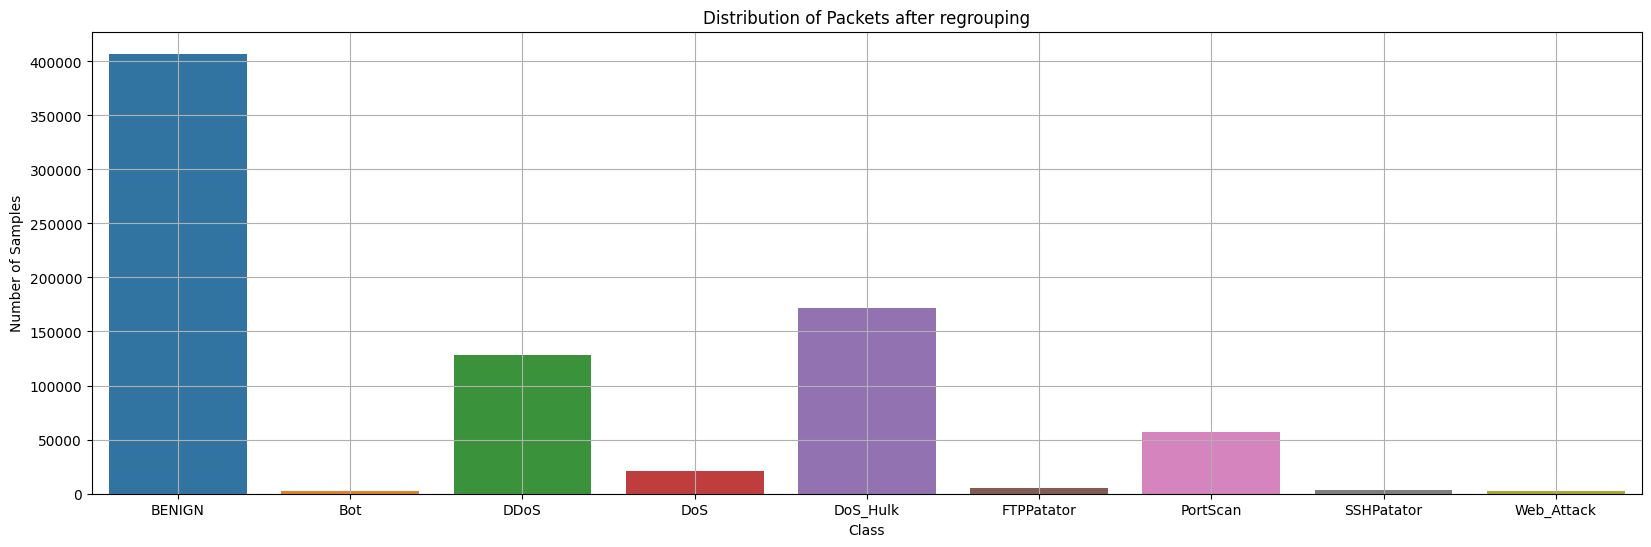

In [19]:
show_class_distribution(df1, "Distribution of Packets after regrouping")

# Feature Selection

In [20]:
# drop the constant columns (which varience is 0)
variances = df1.var(numeric_only=True)
constant_columns = variances[variances == 0].index
df1.drop(constant_columns, axis=1, inplace=True)
print(constant_columns)
print(df1.shape)

Index(['BwdPSHFlags', 'BwdURGFlags', 'FwdAvgBytes/Bulk', 'FwdAvgPackets/Bulk',
       'FwdAvgBulkRate', 'BwdAvgBytes/Bulk', 'BwdAvgPackets/Bulk',
       'BwdAvgBulkRate'],
      dtype='object')
(797276, 71)


In [21]:
print(df1.columns)

Index(['DestinationPort', 'FlowDuration', 'TotalFwdPackets',
       'TotalBackwardPackets', 'TotalLengthofFwdPackets',
       'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowBytes/s', 'FlowPackets/s', 'FlowIATMean', 'FlowIATStd',
       'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd',
       'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd',
       'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'FwdURGFlags',
       'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets/s', 'BwdPackets/s',
       'MinPacketLength', 'MaxPacketLength', 'PacketLengthMean',
       'PacketLengthStd', 'PacketLengthVariance', 'FINFlagCount',
       'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount', 'ACKFlagCount',
       'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount', 'Down/UpRatio',
       'AveragePacketS

# Checking Corelation of columns of dataframe

In [22]:
# Note: The corr() method ignores "not numeric" columns.

corr = df1.corr(method ='pearson', numeric_only=True)
corr

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
DestinationPort,1.000000,-0.211632,-0.003815,-0.003422,0.023678,-0.002692,0.087116,-0.000810,0.140499,0.109747,...,-0.002724,0.000670,-0.043669,-0.034272,-0.050442,-0.034993,-0.188481,-0.031851,-0.188996,-0.184287
FlowDuration,-0.211632,1.000000,0.013651,0.012342,0.071951,0.010015,0.234742,-0.136571,0.106165,0.219625,...,0.009470,-0.000538,0.162994,0.159819,0.212744,0.118806,0.881798,0.254208,0.898643,0.847067
TotalFwdPackets,-0.003815,0.013651,1.000000,0.997833,0.661237,0.995232,0.008637,-0.002509,0.000533,0.001710,...,0.960166,-0.000618,0.044003,0.006670,0.035409,0.045516,0.000526,0.000579,0.000623,0.000409
TotalBackwardPackets,-0.003422,0.012342,0.997833,1.000000,0.657873,0.988177,0.008474,-0.002091,0.000220,0.001380,...,0.954513,0.000026,0.044618,0.004609,0.034620,0.047226,-0.000248,-0.000148,-0.000267,-0.000254
TotalLengthofFwdPackets,0.023678,0.071951,0.661237,0.657873,1.000000,0.656153,0.372006,0.007937,0.351406,0.296461,...,0.684746,-0.006418,0.089960,0.131990,0.142414,0.045058,0.015000,0.017152,0.017785,0.012149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ActiveMin,-0.034993,0.118806,0.045516,0.047226,0.045058,0.041762,0.052128,-0.028896,0.038859,0.046078,...,0.003076,-0.002281,0.919539,0.009157,0.649630,1.000000,0.083576,0.046454,0.092744,0.075171
IdleMean,-0.188481,0.881798,0.000526,-0.000248,0.015000,0.000056,0.161180,-0.118863,0.078402,0.176011,...,-0.001271,0.000560,0.073899,-0.010639,0.040306,0.083576,1.000000,0.098247,0.989531,0.989763
IdleStd,-0.031851,0.254208,0.000579,-0.000148,0.017152,-0.000081,0.062623,-0.037700,0.065421,0.071437,...,0.000575,-0.002513,0.078089,0.086397,0.077769,0.046454,0.098247,1.000000,0.238464,-0.044528
IdleMax,-0.188996,0.898643,0.000623,-0.000267,0.017785,0.000033,0.166007,-0.121650,0.086531,0.181823,...,-0.001140,0.000121,0.093769,0.017563,0.062395,0.092744,0.989531,0.238464,1.000000,0.959158


In [23]:
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

{'FlowIATMax', 'PacketLengthStd', 'FwdPacketLengthMean', 'SubflowBwdBytes', 'FlowIATMean', 'FwdIATStd', 'FwdIATTotal', 'FwdIATMax', 'FlowIATStd', 'BwdPacketLengthMean', 'TotalBackwardPackets', 'TotalFwdPackets', 'FwdPSHFlags', 'AveragePacketSize', 'ActiveMean', 'SubflowFwdPackets', 'PacketLengthMean', 'BwdPacketLengthStd', 'FwdURGFlags', 'FwdPacketLengthMax', 'FwdHeaderLength', 'IdleMax', 'FlowDuration', 'TotalLengthofBwdPackets', 'TotalLengthofFwdPackets', 'BwdPacketLengthMax', 'SubflowBwdPackets', 'FlowPackets/s', 'IdleMean', 'RSTFlagCount', 'MaxPacketLength', 'BwdIATStd'}
32


In [24]:
# dropping corelated coluns
df1.drop(correlated_col, axis=1, inplace=True)
df1.shape

(797276, 39)

In [25]:
df1['Label'].value_counts()

Label
BENIGN        407101
DoS_Hulk      171509
DDoS          128005
PortScan       57305
DoS            20744
FTPPatator      5480
SSHPatator      3071
Web_Attack      2118
Bot             1943
Name: count, dtype: int64

# Saving dataframe after regrouping of class


In [26]:
df1.to_csv('data/cicids2017_regrouping_class_featureselection.csv', index=False)